In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import matplotlib.pyplot as plt
%pylab inline

D:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


D:\ProgramData\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1. Создание регрессионных признаков для учёта сезонностей и трендов

In [2]:
# Загрузка данных, выбрал зону 1231 (та, в которой Empire State Building)
# В файле агрегированные данные за 3 года (с апр. 2013 по май 2016) по зоне 1231. Может, кому пригодится...
data = pd.read_csv('All trips from 1231.csv', index_col=0, parse_dates=True )

In [3]:
# добавляем столбец с праздниками
cal = calendar()
holidays = cal.holidays(start='2013-01-01', end='2016-07-31')

data['date'] = pd.to_datetime(data.index)
data = data.assign(date=data.date.dt.floor('D'))

data['Holiday'] = data.date.isin(holidays).map({False: 0, True:1})
data.drop(['date'], axis=1, inplace=True)
data[-27:-22]

,Trips,Holiday
date,,
2016-05-30 21:00:00,655,1
2016-05-30 22:00:00,491,1
2016-05-30 23:00:00,359,1
2016-05-31 00:00:00,217,0
2016-05-31 01:00:00,131,0


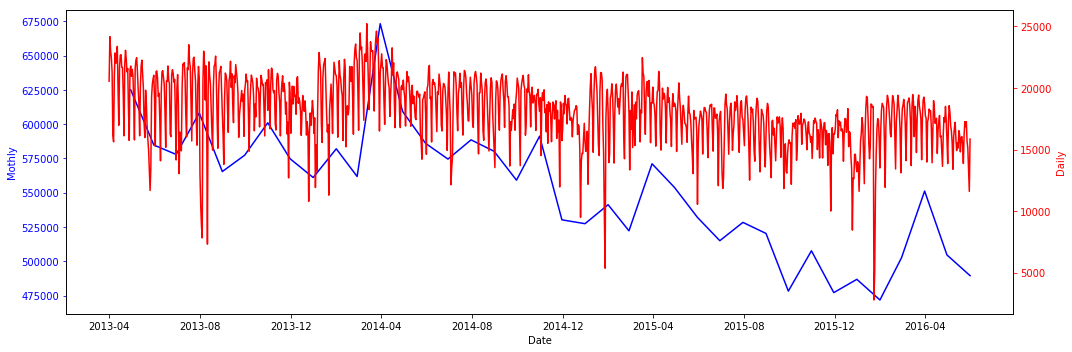

In [4]:
# Посмотрим на данные по поездкам в дневном и месячном тайм-фрейме
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(data.Trips.resample('M').sum(), 'b-')
ax1.set_xlabel('Date')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Mothly', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(data.Trips.resample('D').sum(), 'r-')
ax2.set_ylabel('Daily', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

Как хорошо видно на месячном графике, в данных присутствует тренд и годовая сезонность. Так, например, в апреле каждого года наблюдается пик по количеству поездок.

##### Формирование признаков

Суточную сезонность будем явно моделировать с помощью SARIMAX, а недельную и годовую - с помощью регрессионной компоненты следующего вида:

$s_i=sin([1,…,T]∗2πi/tau), c_i=cos([1,…,T]∗2πi/tau),i=1,…,K.$

Где $T$ — это длина моделируемого ряда,
$tau$ - количество часов в рассматриваемом периоде (для учёта недельной сезонности $tau_w$ = 168, годовой - $tau_y$ = 8766).

Поскольку в данных есть тренд, учтем его полиномом степени $S_y$.

Таким образом, нужно подобрать 3 константы: значения параметров $K_w, K_y$ и степень полинома для учета тренда - $S_y$.
Решать эту задачу будем полным перебором констант используя линейную модель OLS из statsmodels.api. Наилучший набор параметров определим по критерию Акаике.

In [5]:
# добавим столбец с количеством часов от начала наблюдений
data['Hours'] = (data.index-data.index.min()) / np.timedelta64(1, 'h')

In [6]:
%%time
results_regr = []
best_aic = float("inf")
best_param_regr = ()

tau_w = 168
tau_y = 8766 

T_trend = 4
T_yearly = 5
T_weekly = 5


# инициируем матрицу признаков для регресии
exog = pd.DataFrame(index=data.index)

# добавляем столбец с праздниками
exog['Holiday'] = data.Holiday

# добавляем свободный член для регресии
exog = sm.add_constant(exog)

# компоненты для учета тренда (полином степени от 1 до 4)
for Th in range(1, T_trend+1):    
    exog['Hours**'+str(Th)]=(data.Hours)**Th

    # компоненты для учета годовой сезонности
    exog = exog[exog.columns[~exog.columns.str.contains('_y')]] # удаляем столбцы с предыдущей итерации
    for Ty in range(1, T_yearly+1):
        sin_lst_y=[]; cos_lst_y=[]
        
        for h in range(len(data)):
            sin_lst_y.append(np.sin(data.Hours[h]*Ty*2*np.pi/tau_y))
            cos_lst_y.append(np.cos(data.Hours[h]*Ty*2*np.pi/tau_y))
            
        exog['Sin_y'+str(Ty)] = pd.DataFrame(sin_lst_y, index=data.index)
        exog['Cos_y'+str(Ty)] = pd.DataFrame(cos_lst_y, index=data.index)
                   
        # компоненты для учета недельной сезонности
        exog = exog[exog.columns[~exog.columns.str.contains('_w')]] # удаляем столбцы с предыдущей итерации
        for Tw in range(1, T_weekly+1):
            sin_lst_w=[]; cos_lst_w=[] ; aic = 1000000
        
            for h in range(len(data)):
                sin_lst_w.append(np.sin(data.Hours[h]*Tw*2*np.pi/tau_w))
                cos_lst_w.append(np.cos(data.Hours[h]*Tw*2*np.pi/tau_w))
       
            exog['Sin_w'+str(Tw)] = pd.DataFrame(sin_lst_w, index=data.index)
            exog['Cos_w'+str(Tw)] = pd.DataFrame(cos_lst_w, index=data.index)

            # обучаем линейную модель
            train_data = exog
            target = data.Trips

            model_regr = sm.OLS(target, exog).fit()
        
            aic = model_regr.aic
            #сохраняем лучшую модель, aic, параметры
            results_regr.append([(Th, Ty,  Tw), aic])
            
            if aic < best_aic:
                best_model_regr = model_regr
                best_aic = aic
                best_param_regr = (Th, Ty, Tw)
  

D:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

Wall time: 6min 2s


In [7]:
# Топ 5 наборов параметров
result_table = pd.DataFrame(results_regr)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters            aic
64  (3, 3, 5)  406921.627738
69  (3, 4, 5)  406925.079359
74  (3, 5, 5)  406926.687816
39  (2, 3, 5)  406938.448547
44  (2, 4, 5)  406941.789727


Итак, лучший по Акаике набор параметров: степень полинома для аппроксимации тренда: 3, количество Фурье-компонент для годовой сезонности: 3, для недельной: 5

In [8]:
# Посмотрим на столбцы матрицы признаков
exog.columns

Index([u'const', u'Holiday', u'Hours**1', u'Hours**2', u'Hours**3',
       u'Hours**4', u'Sin_y1', u'Cos_y1', u'Sin_y2', u'Cos_y2', u'Sin_y3',
       u'Cos_y3', u'Sin_y4', u'Cos_y4', u'Sin_y5', u'Cos_y5', u'Sin_w1',
       u'Cos_w1', u'Sin_w2', u'Cos_w2', u'Sin_w3', u'Cos_w3', u'Sin_w4',
       u'Cos_w4', u'Sin_w5', u'Cos_w5'],
      dtype='object')

In [9]:
# Удаляем лишние признаки
exog.drop(columns=['Hours**4', 'Sin_y4', 'Sin_y5', 'Cos_y4', 'Cos_y5'], inplace=True)

# Обучаем модель
train_data = exog
target = data.Trips

model_regr = sm.OLS(target, exog).fit()

print "Признаки для регрессии: ", exog.columns
print "Критерий Акаике: ", model_regr.aic

Признаки для регрессии:  Index([u'const', u'Holiday', u'Hours**1', u'Hours**2', u'Hours**3', u'Sin_y1',
       u'Cos_y1', u'Sin_y2', u'Cos_y2', u'Sin_y3', u'Cos_y3', u'Sin_w1',
       u'Cos_w1', u'Sin_w2', u'Cos_w2', u'Sin_w3', u'Cos_w3', u'Sin_w4',
       u'Cos_w4', u'Sin_w5', u'Cos_w5'],
      dtype='object')
Критерий Акаике:  406921.62773813796


In [10]:
exog.head()

,const,Holiday,Hours**1,Hours**2,Hours**3,Sin_y1,Cos_y1,Sin_y2,Cos_y2,Sin_y3,...,Sin_w1,Cos_w1,Sin_w2,Cos_w2,Sin_w3,Cos_w3,Sin_w4,Cos_w4,Sin_w5,Cos_w5
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01 00:00:00,1.0,0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-04-01 01:00:00,1.0,0,1.0,1.0,1.0,0.000717,1.000000,0.001434,0.999999,0.002150,...,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566
2013-04-01 02:00:00,1.0,0,2.0,4.0,8.0,0.001434,0.999999,0.002867,0.999996,0.004301,...,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874
2013-04-01 03:00:00,1.0,0,3.0,9.0,27.0,0.002150,0.999998,0.004301,0.999991,0.006451,...,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724
2013-04-01 04:00:00,1.0,0,4.0,16.0,64.0,0.002867,0.999996,0.005734,0.999984,0.008601,...,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052


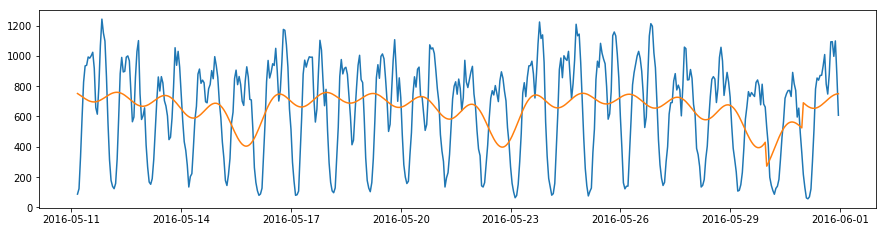

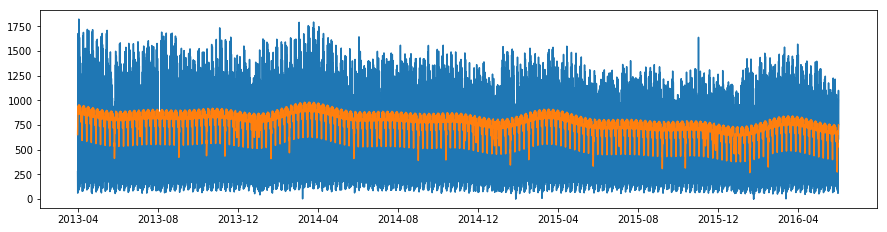

In [11]:
# Посмотрим на график поездок с наложением сезонностей и тренда
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
plt.plot(data.Trips[-500:])
plt.plot(pd.DataFrame(model_regr.predict(exog)[-500:], index=data.index))
pylab.show()

plt.figure(figsize=(15,8))
ax = plt.subplot(212)
plt.plot(data.Trips)
plt.plot(pd.DataFrame(model_regr.predict(exog), index=data.index))
pylab.show()


На рисунке виден нисходящий тренд, недельная сезонность на верхнем графике и годовая - на нижнем. Так же хорошо видны праздники - в эти дни идет снижение среднего количества поездок. 

Далее продолжим моделирование с помощью ARIMA, предполагая, что в данных осталась лишь внутрисуточная сезонность.

### 2. Анализ остатков регрессии

Text(0,0.5,u'Residuals')

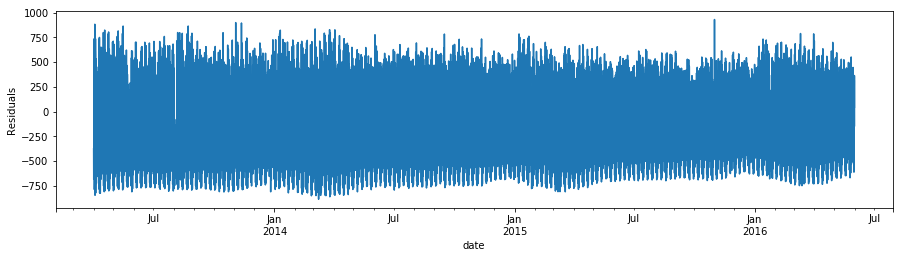

In [12]:
data['trip_res'] = data.Trips - model_regr.predict(exog)

plt.figure(figsize(15,8))
plt.subplot(211)
data.trip_res.plot()
plt.ylabel(u'Residuals')

Видно, что в данных остались закономерности. Идеально подобрать сезонности и тренд не удалось. Остались выбросы, профиль не выглядит равномерным. Еще можно отметить некоторое изменение дисперсии ряда со временем. 
Попробуем учесть этот эффект дополнительным коэффициентом, полученного с помощью скользящей дисперсии с периодом в 1 неделю. 

D:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=168,center=False).std()
  """Entry point for launching an IPython kernel.


Text(0,0.5,u'Residuals with std correction')

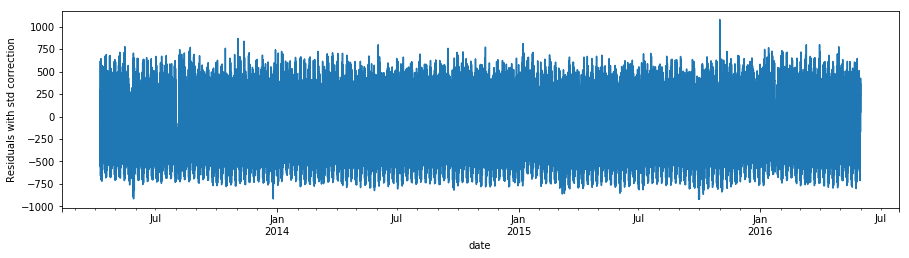

In [13]:
data['std_const'] = np.std(data.trip_res)/pd.rolling_std(data.trip_res,168)
data['trip_res_std'] = data.trip_res*data.std_const

plt.figure(figsize(15,8))
plt.subplot(211)
data.trip_res_std.plot()
plt.ylabel(u'Residuals with std correction')

In [14]:
# Для того, чтобы оценить несмещенность остатков, расчитаем критерий Стьюдента
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(data.trip_res_std[169:], 0)[1])

Критерий Стьюдента: p=0.690559


Остатки несмещены, т.е. распределены равномерно вокруг 0. Будем считать, что сезонность и тренд мы учли и осталась лишь внутридневная сезонность. Её то и будем моделировать с помощью SARIMA

### 3. STL-декомпозиця, подбор гиперпараметров SARIMA

In [15]:
# добавим колонки сезонного (24 часа) и обычного (1 час) дифференцирования 
data['trip_res_diff'] = data.trip_res_std - data.trip_res_std.shift(24)
data['trip_res_diff2'] = data.trip_res_diff - data.trip_res_diff.shift(1)

Критерий Дики-Фуллера: p=1.450584e-10


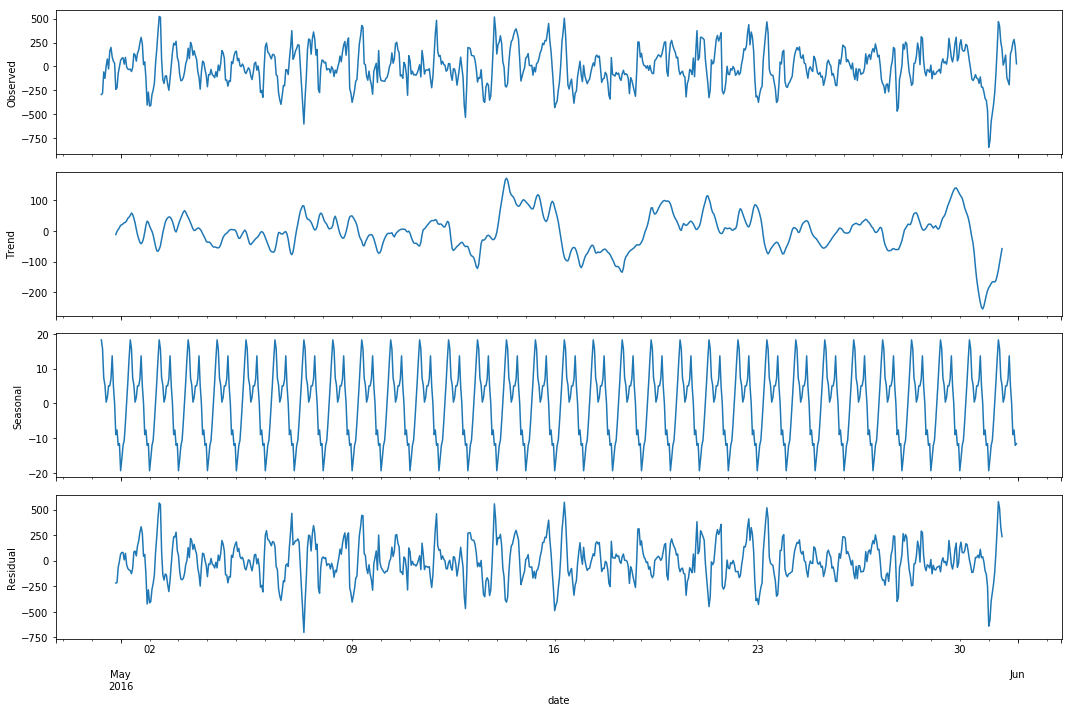

In [16]:
# Посмотрим на результат STL-декомпозиции после сезонного дифференцирования (24 часа)
plt.figure(figsize(15,10))

sm.tsa.seasonal_decompose(data.trip_res_diff[-760:]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data.trip_res_diff[-760:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности. Тренда как такового нет, всплеск 30 мая обусловлен праздничным днем: видимо, не совсем корректно мы их учли... Остановимся на одном сезонном дифференцировании, визуально ряд выглядит вполне стационарно.

### 4. Подбор параметров по ACF и PACF

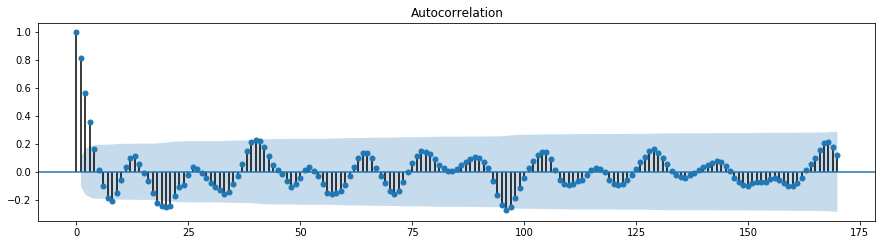

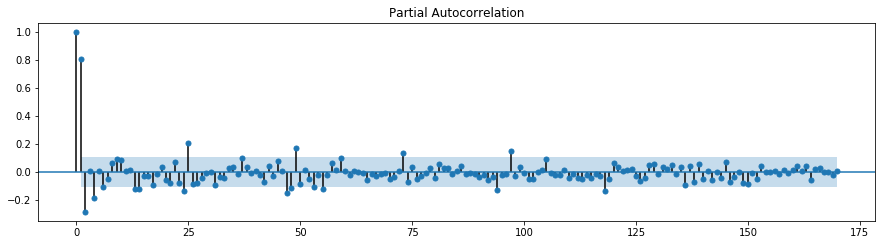

In [17]:
plt.figure(figsize(15,8))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.trip_res_diff[-335:].values.squeeze(), lags=170, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.trip_res_diff[-335:].values.squeeze(), lags=170, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=3, P=4, p=4

In [18]:
ps = range(0, 5)
d=0
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [19]:
from itertools import product

params = product(ps, qs, Ps, Qs)
parameters_list = list(params)
len(parameters_list)

100

Важно! При обучении SARIMA я не использую параметр exog, поскольку буду аппроксимировать не сам ряд количества поездок, а ряд остатков за вычетом регрессионных признаков, полученных выше. Такой подход идентичен SARIMAX, плюс существенно сокращает время расчетов и сходимость метода, поскольку снижает размерность матрицы признаков.

Искать гиперпараметры будем на последних 5 месяцах, иначе очень долго выйдет

In [47]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:

    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model_sarimax=sm.tsa.statespace.SARIMAX(data.trip_res_std[-3600:].astype(float), order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),enforce_invertibility=False).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('LinAlgError:')
        continue
    
    aic = model_sarimax.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model_sarimax
        best_aic = aic
        best_param = param
    results.append([param, model_sarimax.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (4, 3, 0, 0))
('wrong parameters:', (4, 3, 1, 0))
('wrong parameters:', (4, 3, 2, 0))
('wrong parameters:', (4, 3, 3, 0))
('wrong parameters:', (4, 3, 4, 0))
Wall time: 3h 59min 46s


In [48]:
#Топ 5 моделей
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
78  (3, 3, 4, 0)  42563.568932
58  (2, 3, 4, 0)  42729.852455
93  (4, 2, 4, 0)  42733.610414
73  (3, 2, 4, 0)  42735.234089
83  (4, 0, 4, 0)  42736.041957


Посмотрим на точность модели на последнем месяце

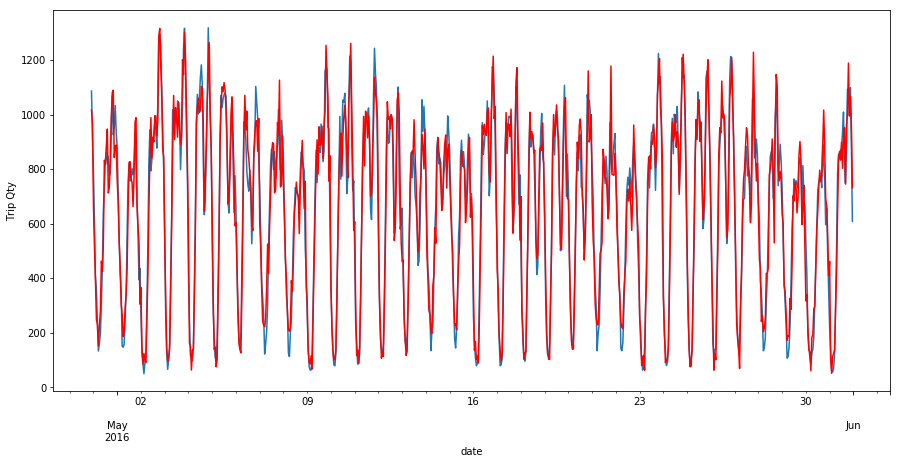

In [49]:
data['model_exog'] = best_model.fittedvalues/data.std_const + model_regr.predict(exog)
plt.figure(figsize(15,7))
data.Trips[-770:].plot()
data.model_exog[-770:].plot(color='r')
#df.model[4350:].plot(color='green')
plt.ylabel('Trip Qty')
pylab.show()

Модель вполне неплохо описывает данные

### 6. Анализ качества модели

Лучшая модель

In [50]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       trip_res_std   No. Observations:                 3600
Model:             SARIMAX(3, 0, 3)x(4, 1, 0, 24)   Log Likelihood              -21274.450
Date:                            Sun, 08 Jul 2018   AIC                          42570.901
Time:                                    05:50:55   BIC                          42638.976
Sample:                                01-03-2016   HQIC                         42595.161
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4525      0.015    160.932      0.000       2.423       2.482
ar.L2         -2.2099      0.027   

Её остатки:

Критерий Стьюдента: p=0.998629
Критерий Дики-Фуллера: p=4.999711e-19


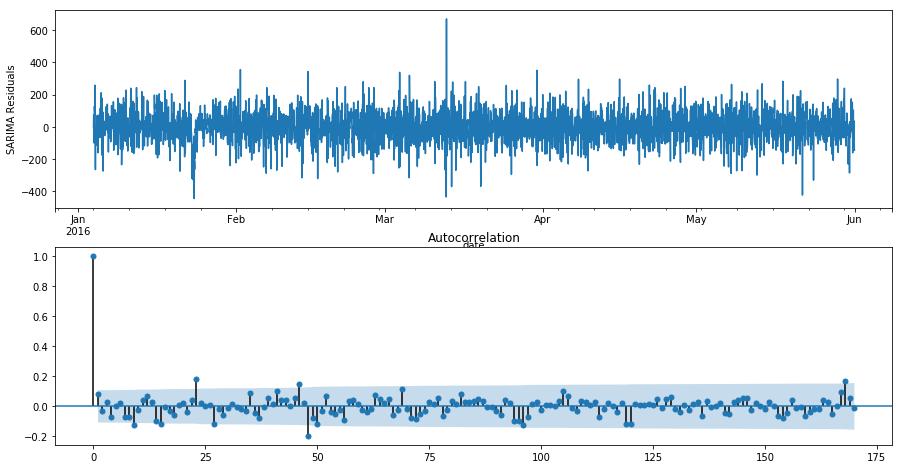

In [51]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[25:].plot()
plt.ylabel(u'SARIMA Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[-335:].values.squeeze(), lags=170, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[25:], 0)[1])
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(best_model.resid[25:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально). Присутствуют выбросы, особенно выраженный в середине марта. Автокорреляция немного осталась - видно на коррелограмме. 

Ряд получился очень длинный, цикличность сложная, с плавающей периодичностью. Некоторые сезонности удалось смоделировать, другие не очень. Изначально в модель были добавлены праздники, что положительно сказалось на качестве модели. А так же учтено изменение дисперсии остатков ряда со временем. 